## scikit-learn digits dataset example

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from keras_ex.GaussianKernel import GaussianKernel, GaussianKernel2, GaussianKernel3

# or copy and paste the definition of `GaussianKernel` here.

In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, \
    Conv1D, Conv2D, Conv3D, \
    Conv2DTranspose, \
    AveragePooling1D, \
    MaxPooling1D, MaxPooling2D, MaxPooling3D, \
    GlobalAveragePooling1D, \
    GlobalMaxPooling1D, GlobalMaxPooling2D, \
    LocallyConnected1D, LocallyConnected2D, \
    concatenate, Flatten, Average, Activation, \
    RepeatVector, Permute, Reshape, Dot, \
    multiply, dot, add, \
    PReLU, \
    Bidirectional, TimeDistributed, \
    SpatialDropout1D, \
    BatchNormalization
from keras.models import Model, Sequential
from keras import losses
from keras.callbacks import BaseLogger, ProgbarLogger, Callback, History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras import initializers
from keras.metrics import categorical_accuracy
from keras.constraints import maxnorm, non_neg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras import backend as K

In [4]:
digits = load_digits()
X, y = digits.data, digits.target

In [5]:
X = X.reshape((X.shape[0], -1))

In [6]:
X_sc = X / 16.0
X_sc.shape

(1797, 64)

In [7]:
X_sc_train, X_sc_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.4, random_state=0)
print(X_sc_train.shape)
print(X_sc_test.shape)
print(y_train.shape)
print(y_test.shape)

(1078, 64)
(719, 64)
(1078,)
(719,)


In [8]:
y_cat = to_categorical(y)
y_cat.shape

(1797, 10)

In [9]:
y_cat_train = to_categorical(y_train)
y_cat_train.shape

(1078, 10)

In [10]:
y_cat_test = to_categorical(y_test)
y_cat_test.shape

(719, 10)

In [11]:
def get_lm(smpl, y, num_lm0=20, random_state=0):
    cls = sorted(np.unique(y))
    np.random.seed(random_state)
    num_feature = np.prod(smpl.shape[1:])
    shape = np.hstack([num_lm0, smpl.shape[1:]])
    num_lm = num_lm0 * len(cls)
    init_list = []
    for ii in cls:
        init_wgt0 = smpl[y==ii]
        init_wgt0 = init_wgt0[np.random.choice(range(init_wgt0.shape[0]), size=num_lm0, replace=False)] + \
                    np.random.normal(scale=0.002, size=num_lm0*num_feature).reshape(shape)
        init_list.append(init_wgt0)
    init_wgt = np.vstack(init_list)
    init_wgt = init_wgt[np.random.permutation(range(init_wgt.shape[0]))]
    return init_wgt

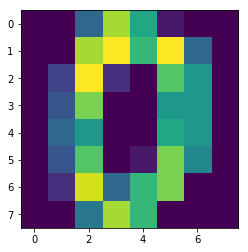

In [12]:
plt.imshow(X[0].reshape((8,8)))

### create model

In [13]:
'''
chose landmarks on input data
pick 20 data each digit
'''
num_lm0 = 20
num_lm = num_lm0 * 10

init_wgt = get_lm(X_sc_train, y_train, num_lm0=num_lm0)
init_wgt.shape

(200, 64)

In [14]:
'''
chose landmarks randomly for gk2
'''
#num_lm2 = 200
num_lm2 = 10
init_lm2 = np.random.random_sample((num_lm2, num_lm))
print(init_lm2.shape)
init_lm2

(10, 200)


array([[ 0.72150955,  0.73561866,  0.82786211, ...,  0.41821092,
         0.89579757,  0.91663392],
       [ 0.53282433,  0.95938975,  0.4606461 , ...,  0.34725582,
         0.52960293,  0.74073731],
       [ 0.19641256,  0.93073513,  0.27859638, ...,  0.40815083,
         0.74430385,  0.842343  ],
       ..., 
       [ 0.03160016,  0.13718324,  0.13656883, ...,  0.02309561,
         0.84539496,  0.80830776],
       [ 0.99771232,  0.54711599,  0.12419023, ...,  0.12487177,
         0.31043308,  0.99672953],
       [ 0.1143734 ,  0.87510768,  0.00171543, ...,  0.69388459,
         0.66499431,  0.46904023]])

In [15]:
np.random.seed(0)

def make_modelz(wgt_embed=None):
    '''==============================
    inputs
    =============================='''
    inp_cls = Input(shape=(10,), name='input_cls')
    inp_img = Input(shape=(64,), name='input_img')
    inp_200 = Input(shape=(num_lm,), name='input_200')
    
    '''==============================
    layers
    =============================='''
    if wgt_embed is None:
        layer_dense_embed = Dense(64, use_bias=False, name='embed')
    else:
        layer_dense_embed = Dense(64, use_bias=False, name='embed', weights=[wgt_embed])
    layer_dense_ae = Dense(64, name='dense_ae')
    
    '''Gaussian Kernel 1'''
    weights1 = [init_wgt, np.log(np.array([1./(2.*64*0.1)]))]
    layer_gk1 = GaussianKernel3(num_lm, 64, name='gkernel1', weights=weights1)
    
    '''Gaussian Kernel 2'''
    weights2 = [init_lm2, np.log(np.array([1./(2.*num_lm*0.1)]))]
    layer_gk2 = GaussianKernel3(10, num_lm, weights=weights2, name='gkernel2')
    
    '''==============================
    models
    =============================='''
    oup_gk1 = layer_gk1(inp_img)
    model_gk1 = Model(inp_img, oup_gk1, name='model_gk1')
    
    oup_gk2 = layer_gk2(inp_200)
    model_classify = Model(inp_200, oup_gk2, name='model_classify')
    
    model_embed = Model(inp_cls, layer_dense_embed(inp_cls), name='model_embed')
    
    # ae
    oup_ae = layer_dense_ae(inp_200)
    model_ae = Model(inp_200, oup_ae, name='model_ae')
    
    # img > img
    oup_img_img = model_ae(oup_gk1)
    oup_img_img = Activation('sigmoid', name='output_img')(oup_img_img)
    model_img_img = Model(inp_img, oup_img_img, name='model_img_img')
    
    # img > cls
    oup_img_cls = model_classify(oup_gk1)
    model_img_cls = Model(inp_img, oup_img_cls, name='model_img_cls')
    
    # cls > img
    model_cls_img = Model(inp_cls, model_img_img(model_embed(inp_cls)), name='model_cls_img')
    
    # cls > cls
    model_cls_cls = Model(inp_cls, model_img_cls(model_embed(inp_cls)), name='model_cls_cls')
    
    '''==============================
    cost functions
    =============================='''
    def cost_cls(y_true, y_pred):
        return losses.categorical_crossentropy(y_true, y_pred)
    def cost_ae(y_true, y_pred):
        return losses.mse(y_true, y_pred)
    def cost_zero(y_true, y_pred):
        return losses.mse(0, y_pred)
    
    '''=== img -> imgA ==='''
    pass_img_imgA = model_img_img(inp_img)
    pass_img_imgA = Activation('linear', name='pass_img_imgA')(pass_img_imgA)
    
    '''=== cls -> img ==='''
    pass_cls_img = model_cls_img(inp_cls)
    pass_cls_img = Activation('linear', name='pass_cls_img')(pass_cls_img)
    
    '''=== cls -> img -> cls ==='''
    pass_cls_img_cls = model_img_cls(pass_cls_img)
    model_cls_img_cls = Model(inp_cls, pass_cls_img_cls, name='model_cls_img_cls')
    pass_cls_img_cls = Activation('softmax', name='pass_cls_img_cls')(pass_cls_img_cls)
    
    '''=== cls > img > cls | cls > img ==='''
    pass_cls_img_cls_img = model_cls_img(model_cls_img_cls(inp_cls))
    pass_cls_img_cls_img = Activation('linear', name='pass_cls_img_cls_img')(pass_cls_img_cls_img)
    
    pass_fit_imgA = Lambda(lambda x: x[0] - x[1], name='pass_fit_imgA')([
        pass_img_imgA,
        pass_cls_img
    ])
    
    model = Model([inp_img, inp_cls],
                  [pass_cls_img, pass_fit_imgA, pass_cls_img_cls, pass_cls_img_cls_img])
    model.compile(loss={
                     'pass_cls_img': cost_ae,
                     'pass_fit_imgA': cost_zero,
                     'pass_cls_img_cls': cost_cls,
                     'pass_cls_img_cls_img': cost_ae,
                  },
                  loss_weights={
                     'pass_cls_img': 1.0,
                     'pass_fit_imgA': 1.0,
                     'pass_cls_img_cls': 1.0,
                     'pass_cls_img_cls_img': 1.0,
                  },
                  metrics=['accuracy'],
                  optimizer='adam')
    
    return {
        'model': model,
        'model_embed': model_embed,
        'model_ae': model_ae,
        'model_gk1': model_gk1,
        'model_classify': model_classify,
        
        'model_img_img': model_img_img,
        'model_img_cls': model_img_cls,
        'model_cls_img': model_cls_img,
        'model_cls_cls': model_cls_cls,
        
        'model_cls_img_cls': model_cls_img_cls,
    }

models = make_modelz()
model = models['model']
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_cls (InputLayer)           (None, 10)            0                                            
____________________________________________________________________________________________________
model_cls_img (Model)            (None, 64)            26305       input_cls[0][0]                  
                                                                   model_cls_img_cls[1][0]          
____________________________________________________________________________________________________
input_img (InputLayer)           (None, 64)            0                                            
____________________________________________________________________________________________________
pass_cls_img (Activation)        (None, 64)            0           model_cls_img[1][0]     

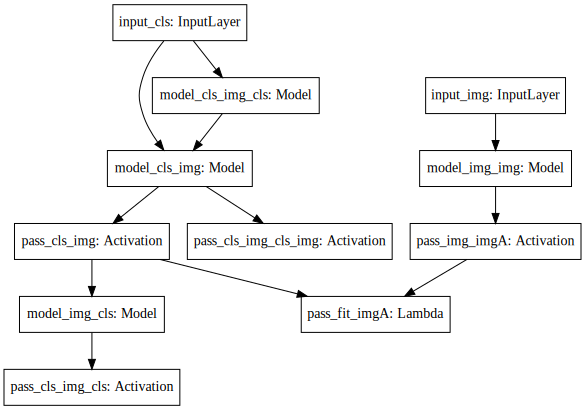

In [16]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### train

In [17]:
model.fit({'input_img': X_sc_train, 'input_cls': y_cat_train},
          {
              'pass_cls_img': X_sc_train,
              'pass_fit_imgA': X_sc_train,
              'pass_cls_img_cls': y_cat_train,
              'pass_cls_img_cls_img': X_sc_train,
          },
          validation_data=(
              {'input_img': X_sc_test, 'input_cls': y_cat_test},
              {
                  'pass_cls_img': X_sc_test,
                  'pass_fit_imgA': X_sc_test,
                  'pass_cls_img_cls': y_cat_test,
                  'pass_cls_img_cls_img': X_sc_test,
              }
          ),
          verbose=0,
          batch_size=32,
          epochs=150)

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [18]:
model.fit({'input_img': X_sc_train, 'input_cls': y_cat_train},
          {
              'pass_cls_img': X_sc_train,
              'pass_fit_imgA': X_sc_train,
              'pass_cls_img_cls': y_cat_train,
              'pass_cls_img_cls_img': X_sc_train,
          },
          validation_data=(
              {'input_img': X_sc_test, 'input_cls': y_cat_test},
              {
                  'pass_cls_img': X_sc_test,
                  'pass_fit_imgA': X_sc_test,
                  'pass_cls_img_cls': y_cat_test,
                  'pass_cls_img_cls_img': X_sc_test,
              }
          ),
          verbose=0,
          batch_size=32,
          epochs=150)

In [19]:
model.fit({'input_img': X_sc_train, 'input_cls': y_cat_train},
          {
              'pass_cls_img': X_sc_train,
              'pass_fit_imgA': X_sc_train,
              'pass_cls_img_cls': y_cat_train,
              'pass_cls_img_cls_img': X_sc_train,
          },
          validation_data=(
              {'input_img': X_sc_test, 'input_cls': y_cat_test},
              {
                  'pass_cls_img': X_sc_test,
                  'pass_fit_imgA': X_sc_test,
                  'pass_cls_img_cls': y_cat_test,
                  'pass_cls_img_cls_img': X_sc_test,
              }
          ),
          verbose=0,
          batch_size=32,
          epochs=150)

In [20]:
model.fit({'input_img': X_sc_train, 'input_cls': y_cat_train},
          {
              'pass_cls_img': X_sc_train,
              'pass_fit_imgA': X_sc_train,
              'pass_cls_img_cls': y_cat_train,
              'pass_cls_img_cls_img': X_sc_train,
          },
          validation_data=(
              {'input_img': X_sc_test, 'input_cls': y_cat_test},
              {
                  'pass_cls_img': X_sc_test,
                  'pass_fit_imgA': X_sc_test,
                  'pass_cls_img_cls': y_cat_test,
                  'pass_cls_img_cls_img': X_sc_test,
              }
          ),
          verbose=0,
          batch_size=32,
          epochs=150)

In [21]:
model.fit({'input_img': X_sc_train, 'input_cls': y_cat_train},
          {
              'pass_cls_img': X_sc_train,
              'pass_fit_imgA': X_sc_train,
              'pass_cls_img_cls': y_cat_train,
              'pass_cls_img_cls_img': X_sc_train,
          },
          validation_data=(
              {'input_img': X_sc_test, 'input_cls': y_cat_test},
              {
                  'pass_cls_img': X_sc_test,
                  'pass_fit_imgA': X_sc_test,
                  'pass_cls_img_cls': y_cat_test,
                  'pass_cls_img_cls_img': X_sc_test,
              }
          ),
          verbose=0,
          batch_size=32,
          epochs=150)

In [22]:
model.fit({'input_img': X_sc_train, 'input_cls': y_cat_train},
          {
              'pass_cls_img': X_sc_train,
              'pass_fit_imgA': X_sc_train,
              'pass_cls_img_cls': y_cat_train,
              'pass_cls_img_cls_img': X_sc_train,
          },
          validation_data=(
              {'input_img': X_sc_test, 'input_cls': y_cat_test},
              {
                  'pass_cls_img': X_sc_test,
                  'pass_fit_imgA': X_sc_test,
                  'pass_cls_img_cls': y_cat_test,
                  'pass_cls_img_cls_img': X_sc_test,
              }
          ),
          verbose=0,
          batch_size=32,
          epochs=150)

In [23]:
model.fit({'input_img': X_sc_train, 'input_cls': y_cat_train},
          {
              'pass_cls_img': X_sc_train,
              'pass_fit_imgA': X_sc_train,
              'pass_cls_img_cls': y_cat_train,
              'pass_cls_img_cls_img': X_sc_train,
          },
          validation_data=(
              {'input_img': X_sc_test, 'input_cls': y_cat_test},
              {
                  'pass_cls_img': X_sc_test,
                  'pass_fit_imgA': X_sc_test,
                  'pass_cls_img_cls': y_cat_test,
                  'pass_cls_img_cls_img': X_sc_test,
              }
          ),
          verbose=0,
          batch_size=32,
          epochs=150)

In [24]:
model.fit({'input_img': X_sc_train, 'input_cls': y_cat_train},
          {
              'pass_cls_img': X_sc_train,
              'pass_fit_imgA': X_sc_train,
              'pass_cls_img_cls': y_cat_train,
              'pass_cls_img_cls_img': X_sc_train,
          },
          validation_data=(
              {'input_img': X_sc_test, 'input_cls': y_cat_test},
              {
                  'pass_cls_img': X_sc_test,
                  'pass_fit_imgA': X_sc_test,
                  'pass_cls_img_cls': y_cat_test,
                  'pass_cls_img_cls_img': X_sc_test,
              }
          ),
          verbose=0,
          batch_size=32,
          epochs=150)

In [25]:
model.fit({'input_img': X_sc_train, 'input_cls': y_cat_train},
          {
              'pass_cls_img': X_sc_train,
              'pass_fit_imgA': X_sc_train,
              'pass_cls_img_cls': y_cat_train,
              'pass_cls_img_cls_img': X_sc_train,
          },
          validation_data=(
              {'input_img': X_sc_test, 'input_cls': y_cat_test},
              {
                  'pass_cls_img': X_sc_test,
                  'pass_fit_imgA': X_sc_test,
                  'pass_cls_img_cls': y_cat_test,
                  'pass_cls_img_cls_img': X_sc_test,
              }
          ),
          verbose=0,
          batch_size=32,
          epochs=150)

In [26]:
model.fit({'input_img': X_sc_train, 'input_cls': y_cat_train},
          {
              'pass_cls_img': X_sc_train,
              'pass_fit_imgA': X_sc_train,
              'pass_cls_img_cls': y_cat_train,
              'pass_cls_img_cls_img': X_sc_train,
          },
          validation_data=(
              {'input_img': X_sc_test, 'input_cls': y_cat_test},
              {
                  'pass_cls_img': X_sc_test,
                  'pass_fit_imgA': X_sc_test,
                  'pass_cls_img_cls': y_cat_test,
                  'pass_cls_img_cls_img': X_sc_test,
              }
          ),
          verbose=0,
          batch_size=32,
          epochs=150)

### img > associated img

In [27]:
pred_img = models['model_img_img'].predict({'input_img': X_sc, 'input_cls': y_cat}, batch_size=32, verbose=1)
print(pred_img.shape)

1728/1797 [===========================>..] - ETA: 0s(1797, 64)


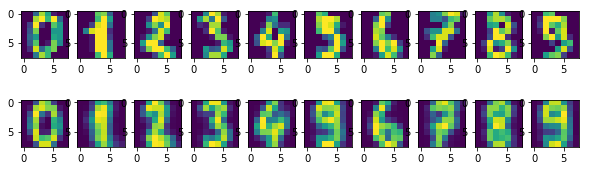

In [28]:
nrows=2
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3))

for jj in range(ncols):
    iplt = subs[0, jj]
    img_array = X_sc[jj].reshape((8,8))
    iplt.imshow(img_array)
    iplt = subs[1, jj]
    img_array = pred_img[jj].reshape((8,8))
    iplt.imshow(img_array)

0


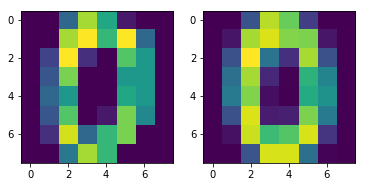

In [29]:
idx = 0
print(y[idx])
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(X_sc[idx].reshape((8,8)))
subs[1].imshow(pred_img[idx].reshape((8,8)))

### abstract images of digits

In [30]:
pred_img = models['model_cls_img'].predict({'input_img': X_sc, 'input_cls': y_cat}, batch_size=32, verbose=1)
print(pred_img.shape)

1760/1797 [============================>.] - ETA: 0s(1797, 64)


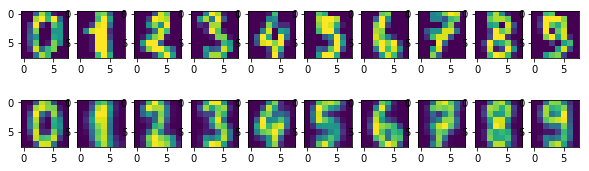

In [31]:
nrows=2
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3))

for jj in range(ncols):
    iplt = subs[0, jj]
    img_array = X_sc[jj].reshape((8,8))
    iplt.imshow(img_array)
    iplt = subs[1, jj]
    img_array = pred_img[jj].reshape((8,8))
    iplt.imshow(img_array)

### plot weights of embed layer

(10, 64)


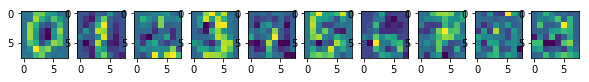

In [32]:
wgt_dense = models['model_embed'].get_layer('embed').get_weights()[0]
#wgt_dense = 1 / (1 + np.exp(-wgt_dense))
print(wgt_dense.shape)

nrows=1
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3))

for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[jj]
        img_array = wgt_dense[jj].reshape((8,8))
        iplt.imshow(img_array)

10/10 [==============================] - 0s
(10, 64)


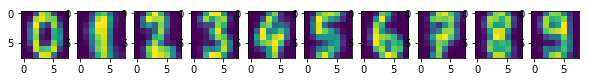

In [33]:
pred_img = models['model_img_img'].predict({'input_img': wgt_dense}, batch_size=32, verbose=1)
print(pred_img.shape)

nrows=1
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3))

for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[jj]
        img_array = pred_img[jj].reshape((8,8))
        iplt.imshow(img_array)

### plot output of model_embed

In [34]:
pred_ae_embed = models['model_embed'].predict(y_cat)
pred_ae_embed.shape

(1797, 64)

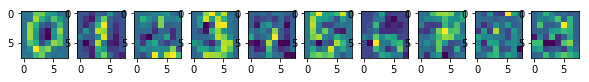

In [35]:
nrows=1
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3))

for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[jj]
        img_array = pred_ae_embed[jj].reshape((8,8))
        iplt.imshow(img_array)

### plot output of GaussianKernel layer #1

In [36]:
pred_imgA_train = models['model_img_img'].predict({'input_img': X_sc_train}, batch_size=32, verbose=1)
print(pred_imgA_train.shape)

 608/1078 [===============>..............] - ETA: 0s(1078, 64)


 608/1078 [===============>..............] - ETA: 0s

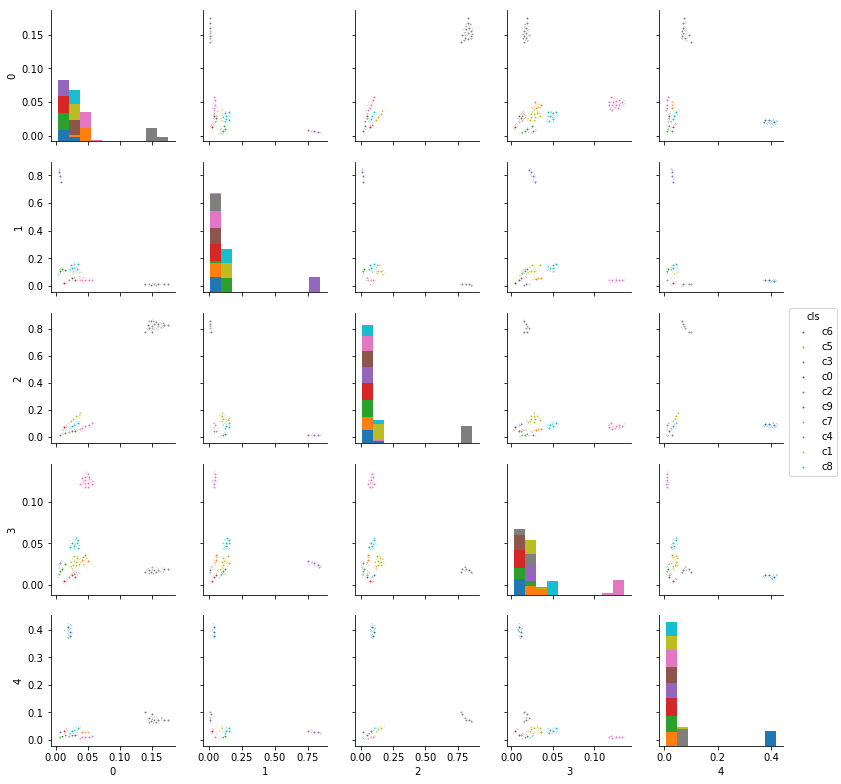

In [37]:
gk1_pred = models['model_gk1'].predict({'input_img': pred_imgA_train}, batch_size=32, verbose=1)
df = pd.DataFrame(gk1_pred[:,:5])
df['cls'] = ['c'+str(ee) for ee in y_train]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

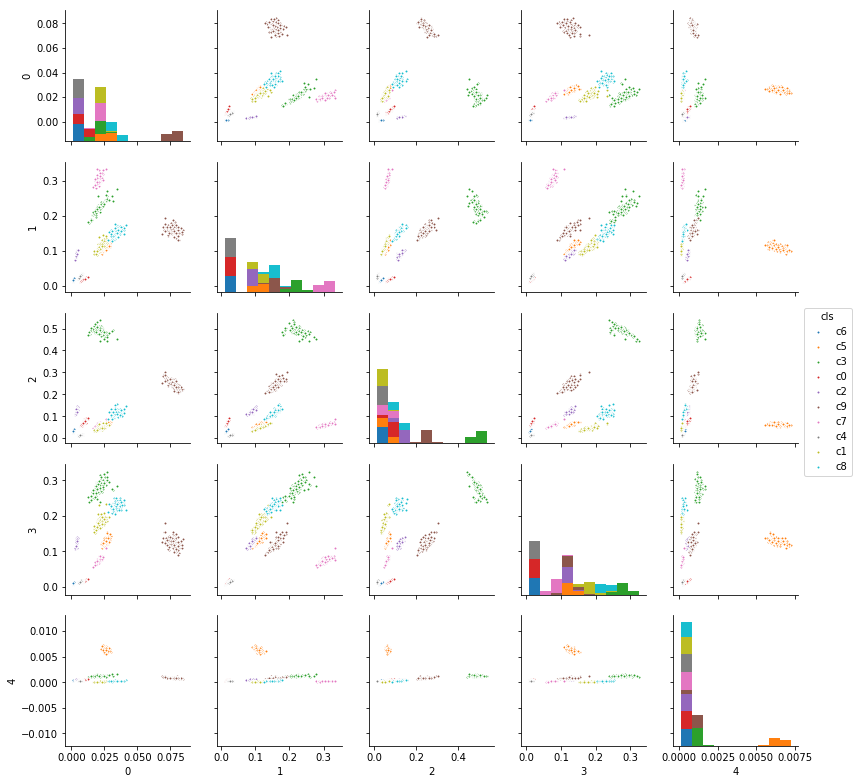

In [38]:
df = pd.DataFrame(gk1_pred[:,50:55])
df['cls'] = ['c'+str(ee) for ee in y_train]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

In [39]:
'''gamma of GaussianKernel layer #1'''
np.exp(models['model_gk1'].get_layer('gkernel1').get_weights()[1])

array([ 0.4521172], dtype=float32)

In [40]:
lm2 = models['model_classify'].get_layer('gkernel2').get_weights()[0]
print(lm2.shape)

(10, 200)


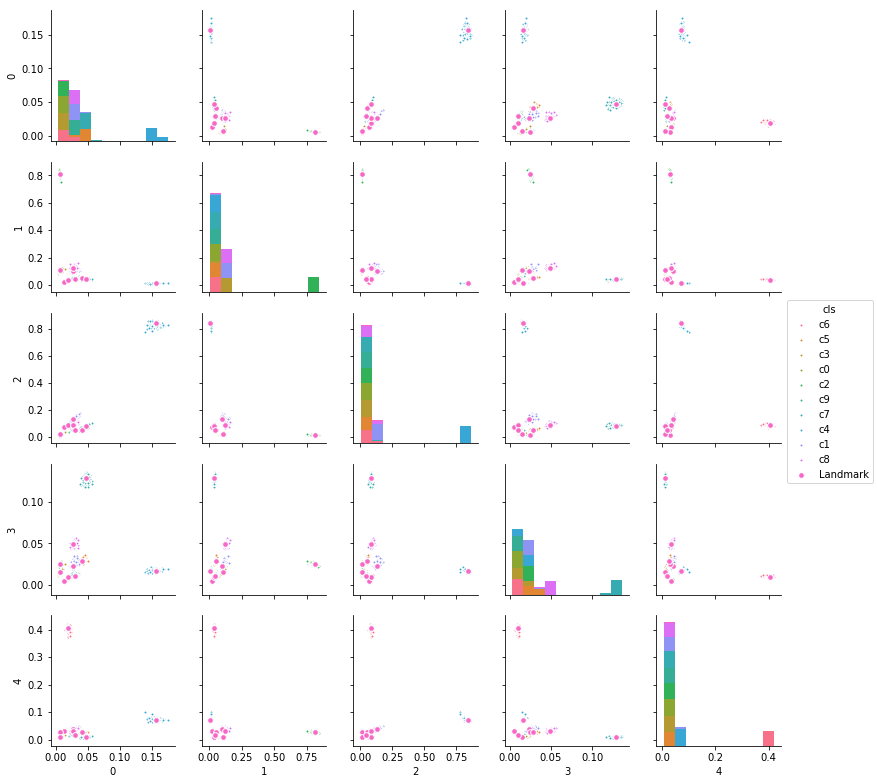

In [41]:
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,:5])
df['cls'] = ['c'+str(ee) for ee in y_train] + ['Landmark']*lm2.shape[0]
sns.pairplot(df, markers=['.']*10+['8'], hue='cls', size=2.2)

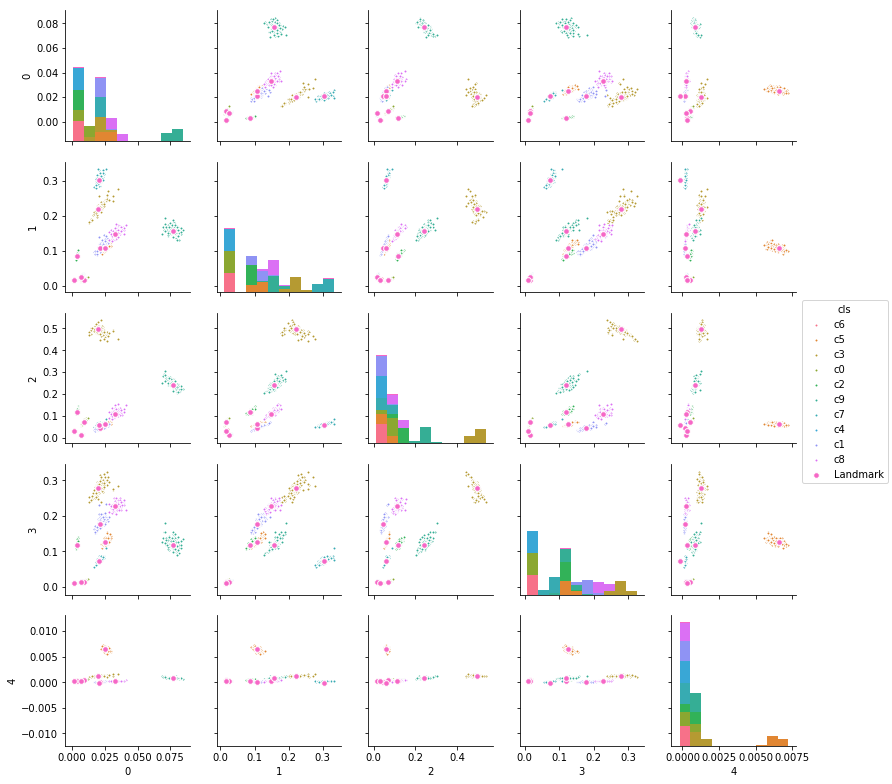

In [42]:
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,50:55])
df['cls'] = ['c'+str(ee) for ee in y_train] + ['Landmark']*lm2.shape[0]
sns.pairplot(df, markers=['.']*10+['8'], hue='cls', size=2.2)

In [43]:
pred_imgA_test = models['model_img_img'].predict({'input_img': X_sc_test}, batch_size=32, verbose=1)
print(pred_imgA_train.shape)

576/719 [=======================>......] - ETA: 0s(1078, 64)


640/719 [=========================>....] - ETA: 0s

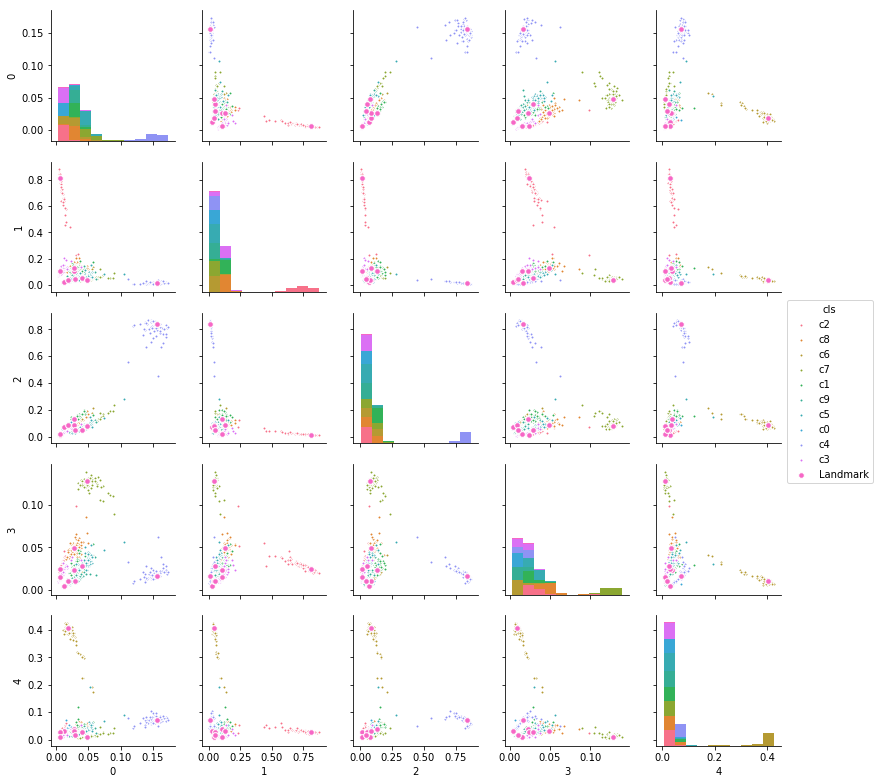

In [44]:
gk1_pred = models['model_gk1'].predict({'input_img': pred_imgA_test}, batch_size=32, verbose=1)
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,:5])
df['cls'] = ['c'+str(ee) for ee in y_test] + ['Landmark']*lm2.shape[0]
sns.pairplot(df, markers=['.']*10+['8'], hue='cls', size=2.2)

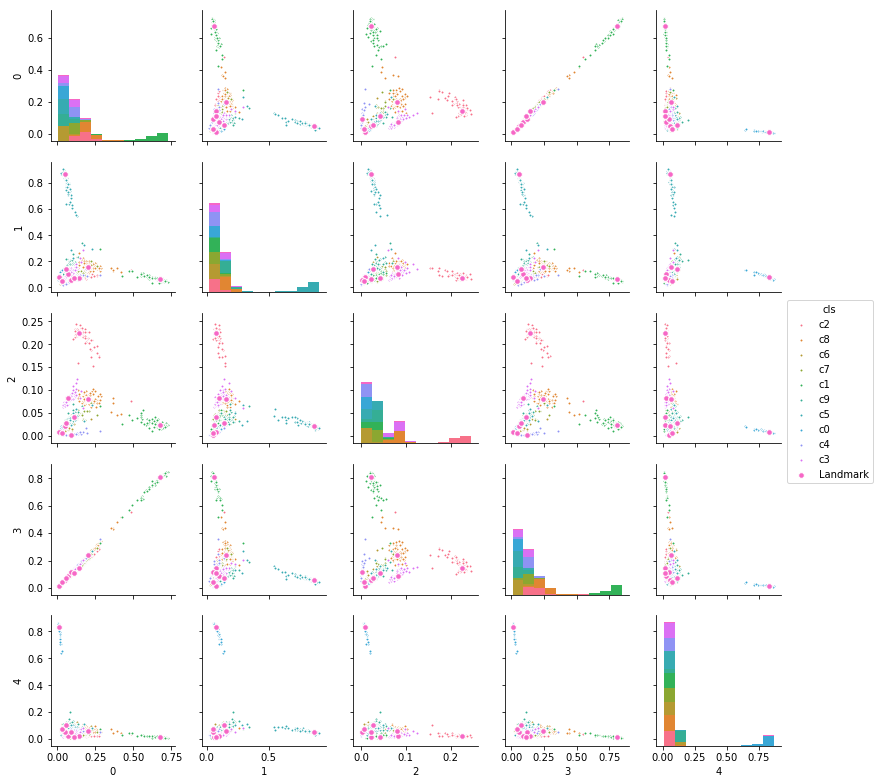

In [45]:
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,5:10])
df['cls'] = ['c'+str(ee) for ee in y_test] + ['Landmark']*lm2.shape[0]
sns.pairplot(df, markers=['.']*10+['8'], hue='cls', size=2.2)

In [46]:
pred_img = models['model_cls_img'].predict(y_cat_train)
pred_img.shape

(1078, 64)

 608/1078 [===============>..............] - ETA: 0s

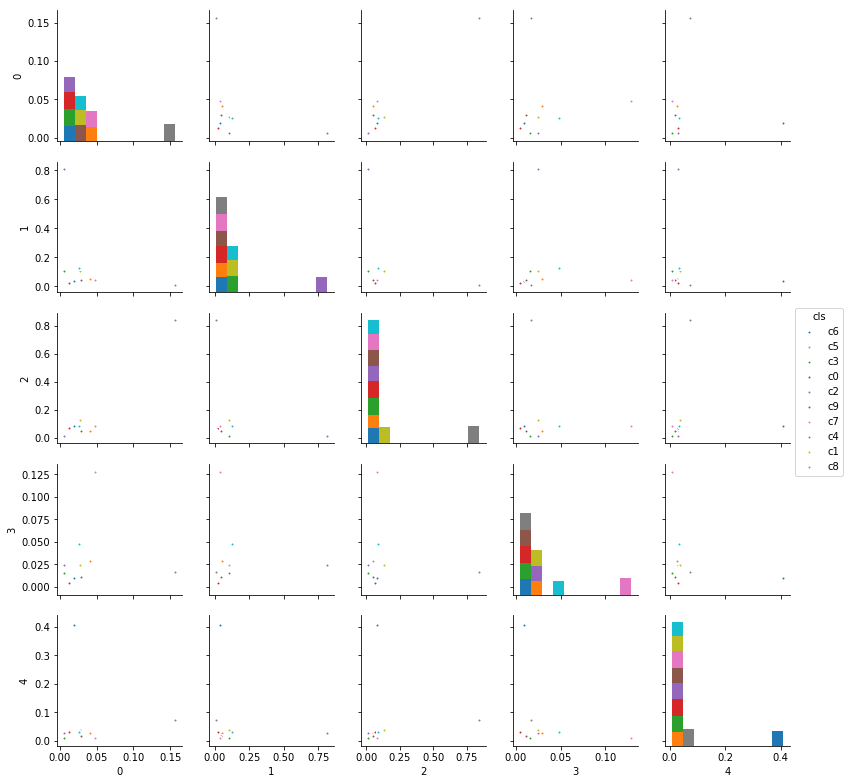

In [47]:
gk1_pred = models['model_gk1'].predict({'input_img': pred_img}, batch_size=32, verbose=1)
df = pd.DataFrame(gk1_pred[:,:5])
df['cls'] = ['c'+str(ee) for ee in y_train]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

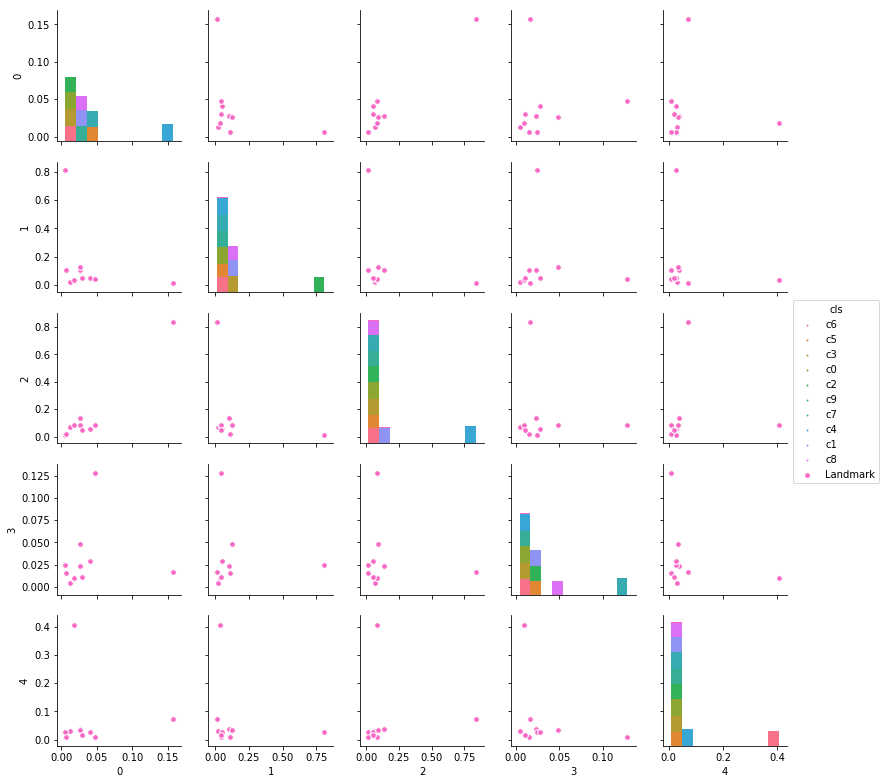

In [48]:
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,:5])
df['cls'] = ['c'+str(ee) for ee in y_train] + ['Landmark']*lm2.shape[0]
sns.pairplot(df, markers=['.']*10+['8'], hue='cls', size=2.2)

### landmarks

In [49]:
wgt = models['model_img_img'].get_layer('gkernel1').get_weights()[0]
wgt.shape

(200, 64)

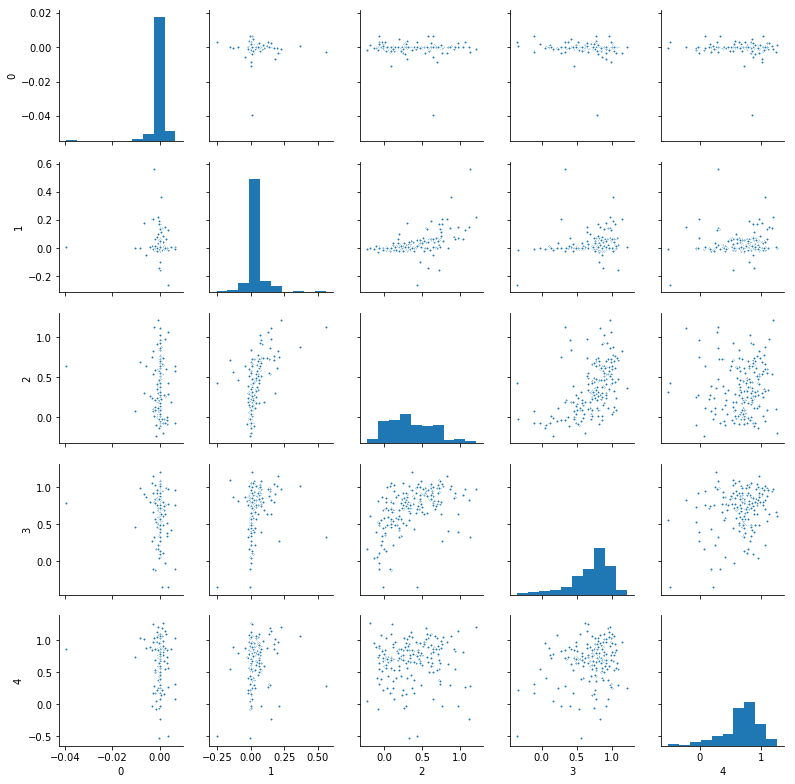

In [50]:
df = pd.DataFrame(wgt[:,:5])
sns.pairplot(df, markers='.', size=2.2)

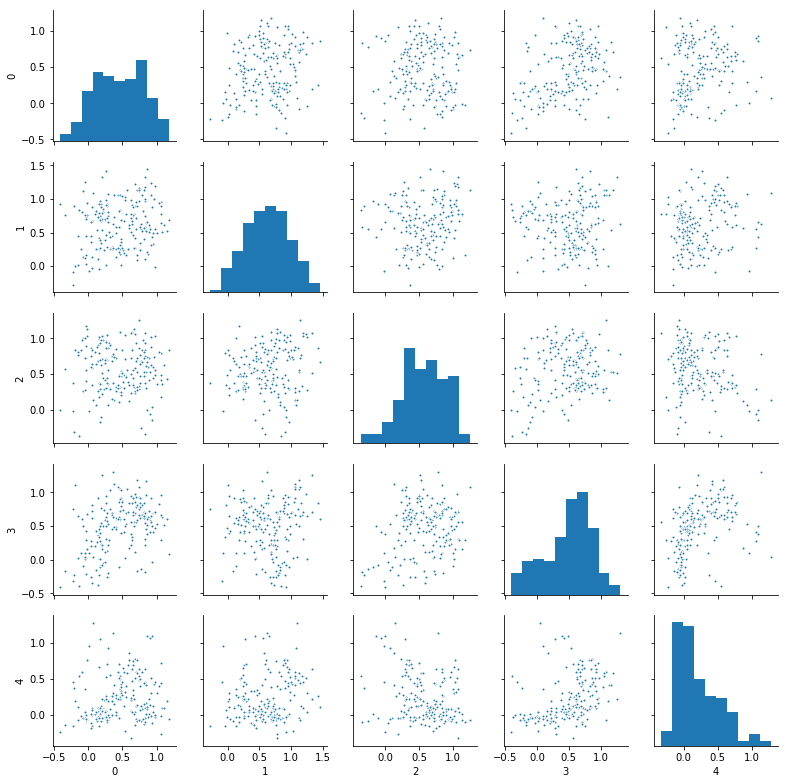

In [51]:
df = pd.DataFrame(wgt[:,50:55])
sns.pairplot(df, markers='.', size=2.2)

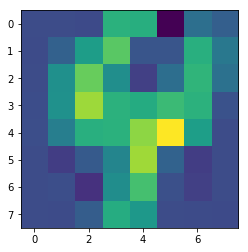

In [52]:
plt.imshow(wgt[0].reshape((8,8)))

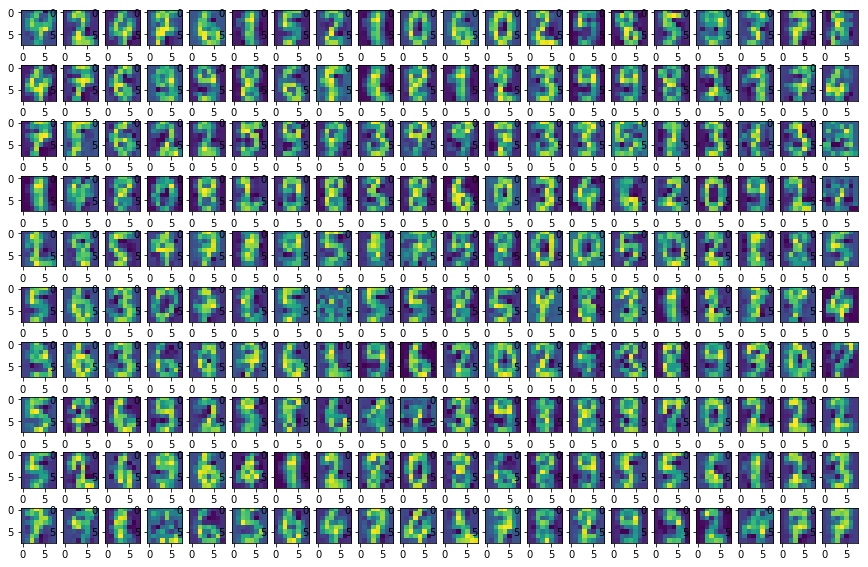

In [53]:
nrows = 10
ncols = num_lm0
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[ii,jj]
        img_array = wgt[ii*ncols+jj].reshape((8, 8))
        iplt.imshow(img_array)

### img > img > cls

In [54]:
pred_imgA_train = models['model_img_img'].predict({'input_img': X_sc_train}, batch_size=32, verbose=1)
print(pred_imgA_train.shape)

 576/1078 [===============>..............] - ETA: 0s(1078, 64)


In [55]:
pred_cls_train = models['model_img_cls'].predict({'input_img': pred_imgA_train})
pred_cls_train.shape

(1078, 10)

In [56]:
print(confusion_matrix(y_train, np.argmax(pred_cls_train, axis=1)))
print(classification_report(y_train, np.argmax(pred_cls_train, axis=1)))

[[118   0   0   0   0   0   0   0   0   0]
 [  0 109   0   0   0   0   0   0   0   0]
 [  0   0 106   0   0   0   0   0   0   0]
 [  0   0   0 113   0   0   0   0   0   0]
 [  0   0   0   0 118   0   0   0   0   0]
 [  0   0   0   0   0  93   0   0   0   0]
 [  0   0   0   0   0   0 105   0   0   0]
 [  0   0   0   0   0   0   0 114   0   0]
 [  0   0   0   0   0   0   0   0  96   0]
 [  0   0   0   0   0   0   0   0   0 106]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       118
          1       1.00      1.00      1.00       109
          2       1.00      1.00      1.00       106
          3       1.00      1.00      1.00       113
          4       1.00      1.00      1.00       118
          5       1.00      1.00      1.00        93
          6       1.00      1.00      1.00       105
          7       1.00      1.00      1.00       114
          8       1.00      1.00      1.00        96
          9       1.00      1.00      

In [57]:
pred_imgA_test = models['model_img_img'].predict({'input_img': X_sc_test}, batch_size=32, verbose=1)
print(pred_imgA_test.shape)

416/719 [================>.............] - ETA: 0s(719, 64)


In [58]:
pred_cls_test = models['model_img_cls'].predict({'input_img': pred_imgA_test})
print(pred_cls_test.shape)
pred_cls_test[:3]

(719, 10)


array([[  2.30486876e-06,   1.82098393e-05,   9.57591295e-01,
          8.76388513e-05,   8.48755974e-07,   4.19840444e-06,
          2.11083261e-06,   5.11563303e-06,   2.31866215e-05,
          1.37575995e-07],
       [  8.85892041e-06,   1.48974545e-03,   2.30107034e-05,
          1.20743629e-04,   1.22379079e-05,   1.03204831e-04,
          4.01467832e-06,   1.42381512e-04,   5.94404399e-01,
          5.29872123e-05],
       [  2.14775514e-06,   1.56037422e-05,   9.65295374e-01,
          9.46242872e-05,   7.51918151e-07,   3.74442993e-06,
          1.79640529e-06,   4.46851800e-06,   1.97283625e-05,
          1.34847369e-07]], dtype=float32)

In [59]:
print(confusion_matrix(y_test, np.argmax(pred_cls_test, axis=1)))
print(classification_report(y_test, np.argmax(pred_cls_test, axis=1)))

[[60  0  0  0  0  0  0  0  0  0]
 [ 0 72  0  0  0  0  0  0  1  0]
 [ 0  1 69  0  0  0  0  1  0  0]
 [ 0  0  0 70  0  0  0  0  0  0]
 [ 0  0  0  0 63  0  0  0  0  0]
 [ 0  0  0  0  0 85  1  0  2  1]
 [ 0  0  0  0  0  0 75  0  1  0]
 [ 0  0  0  0  0  0  0 64  1  0]
 [ 0  1  0  0  0  0  0  0 77  0]
 [ 0  0  0  0  0  0  0  0  1 73]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        60
          1       0.97      0.99      0.98        73
          2       1.00      0.97      0.99        71
          3       1.00      1.00      1.00        70
          4       1.00      1.00      1.00        63
          5       1.00      0.96      0.98        89
          6       0.99      0.99      0.99        76
          7       0.98      0.98      0.98        65
          8       0.93      0.99      0.96        78
          9       0.99      0.99      0.99        74

avg / total       0.99      0.98      0.98       719



In [60]:
f1_score(y_test, np.argmax(pred_cls_test, axis=1), average='macro')

0.98567833321973164

### incorrect data

In [61]:
np.c_[y_test, np.argmax(pred_cls_test, axis=1)]
idx = np.arange(y_test.shape[0])[~(y_test==np.argmax(pred_cls_test, axis=1))]
idx

array([ 66, 109, 118, 124, 130, 181, 331, 472, 503, 696, 701])

In [62]:
pred_cls_test[idx][:3]

array([[  3.44109467e-05,   1.24051655e-03,   1.70635642e-03,
          2.76829535e-03,   2.72814887e-05,   2.79219414e-04,
          7.98124074e-06,   2.66033337e-02,   2.06436068e-02,
          4.87845100e-05],
       [  4.10586654e-05,   1.36612239e-03,   7.54856082e-05,
          4.76114219e-04,   8.94817349e-05,   4.81566676e-04,
          1.05862200e-05,   1.82398222e-02,   7.95252025e-02,
          8.20728164e-05],
       [  3.10469157e-04,   7.32767023e-03,   2.89310992e-04,
          4.42663964e-04,   1.54421595e-03,   8.16961867e-04,
          3.89014161e-03,   3.27715068e-04,   2.18806807e-02,
          5.60902554e-05]], dtype=float32)

In [63]:
pred_cls_cls_img_test = models['model_cls_img'].predict({'input_cls': pred_cls_test})

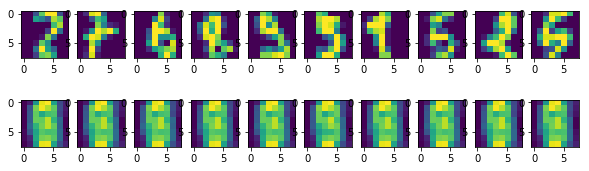

In [64]:
nrows=2
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3))

for jj in range(ncols):
    iplt = subs[0, jj]
    img_array = X_sc_test[idx[jj]].reshape((8,8))
    iplt.imshow(img_array)
    iplt = subs[1, jj]
    img_array = pred_cls_cls_img_test[idx[jj]].reshape((8,8))
    iplt.imshow(img_array)